In [2]:
import numpy as np 
import pandas as pd
import heapq
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sklearn
from sklearn.cluster import KMeans
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import chi2
from scipy import spatial
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from scipy import stats
from scipy.stats import beta
from scipy.stats import norm

import tensorflow as tf
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
def embed(input):
  return model(input)

nltk.download('punkt')
nltk.download('stopwords')

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
sns.set_style("darkgrid")
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


In [3]:
!pip install surprise
import surprise as sp
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise.model_selection import GridSearchCV

     |████████████████████████████████| 11.8MB 256kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617641 sha256=6614d7a6a7e8a0a60c86bb24071e88a323b9c89f493b313ad84b4e371b9675d6
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


### Loading datasets:

In [4]:
movie_df = pd.read_csv('/content/drive/MyDrive/imdb_datasets/imdb_movies.csv')
rating_df = pd.read_csv('/content/drive/MyDrive/imdb_datasets/imdb_ratings.csv')
movie_df = movie_df[movie_df['country'].str.contains('USA')]
movie_df.set_index('movie_id', inplace=True)
rating_df.set_index('movie_id', inplace=True)

### Label-encoding genres and Filtering:

In [5]:
genres_onehot = movie_df['genres'].str.get_dummies(sep=',')
genres = list()
for index, row in movie_df.iterrows():
    a = row['genres']
    chunks = a.split(',')
    for i in chunks:
      genres.append(i)
        
c = Counter(genres)
n = 10
most_common = [key for key, val in c.most_common(n)]
genres_onehot = genres_onehot[most_common]
movie_df = pd.merge(movie_df, genres_onehot, left_index=True, right_index=True)

In [6]:
threshold = 1000
movie_df = movie_df[movie_df['point_volume'] >= threshold]
rating_df = rating_df[rating_df['all_count'] >= threshold]

In [7]:
movie_df.head()

,name,org_name,date,title_year,point,point_volume,metascore,user_reviews,critic_reviews,director,writer,story_line,cast,genres,country,language,budget,world_gross,usa_gross,runtime,production_companies,dollar_budget,w_gross_money,u_gross_money,inflation_coeff,casts_id,BlogPage,CompPage,HomePage,release_month,release_day,keywords,Drama,Documentary,Comedy,Thriller,Romance,Action,Horror,Crime,Adventure,Mystery
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0003643,The Avenging Conscience: or 'Thou Shalt Not Kill',The Avenging Conscience: or 'Thou Shalt Not Kill',1914-08-24,1914.0,6.4,1105.0,NaN,14.0,11.0,D.W. Griffith,"Edgar Allan Poe,D.W. Griffith",Thwarted by his despotic uncle from continuing...,"Henry B. Walthall,Blanche Sweet,Ralph Lewis,Ro...","Crime,Drama,Horror",USA,English,NaN,NaN,NaN,78.0,Majestic Motion Picture Company,NaN,NaN,NaN,26.145238,castIDs_not_provided,0,0,0,8.0,24.0,"dreamlike,dream-sequences,dream-sequence,murde...",1,0,0,0,0,0,1,1,0,0
tt0004181,Judith of Bethulia,Judith of Bethulia,1914-03-08,1914.0,6.1,1239.0,NaN,16.0,9.0,D.W. Griffith,"Thomas Bailey Aldrich,D.W. Griffith","A fascinating work of high artistry, ""Judith o...","Blanche Sweet,Mae Marsh,Kate Bruce,J. Jiquel L...",Drama,USA,English,$40000,NaN,NaN,NaN,Biograph Company,40000.0,NaN,NaN,26.145238,castIDs_not_provided,0,0,0,3.0,8.0,"female-tied-up,decapitation,female-protagonist...",1,0,0,0,0,0,0,0,0,0
tt0004707,Tillie's Punctured Romance,Tillie's Punctured Romance,1914-12-21,1914.0,6.3,3250.0,NaN,38.0,18.0,"Mack Sennett, Charles Bennett","Mack Sennett, Charles Bennett",Charlie talks wealthy farmer's daughter Tillie...,"Marie Dressler,Mabel Normand,Charles Bennett,C...",Comedy,USA,English,$50000,NaN,NaN,74.0,Keystone Film Company,50000.0,NaN,NaN,26.145238,castIDs_not_provided,0,0,0,12.0,21.0,"slapstick-comedy,car-in-water,morality-play,pi...",0,0,1,0,0,0,0,0,0,0
tt0004972,The Birth of a Nation,The Birth of a Nation,1915-03-21,1915.0,6.3,22213.0,NaN,368.0,97.0,D.W. Griffith,"Thomas Dixon Jr.,Thomas Dixon Jr.","Two brothers, Phil and Ted Stoneman, visit the...","Henry B. Walthall,Mae Marsh,Mary Alden,George ...","Drama,History,War",USA,English,$100000,NaN,NaN,195.0,"David W. Griffith Corp.,Epoch Producing Corpor...",100000.0,NaN,NaN,25.537209,castIDs_not_provided,0,0,0,3.0,21.0,"ku-klux-klan,civil-war,reconstruction-era,u.s....",1,0,0,0,0,0,0,0,0,0
tt0005078,The Cheat,The Cheat,1915-12-13,1915.0,6.6,2305.0,NaN,38.0,19.0,Cecil B. DeMille,"Hector Turnbull,Jeanie Macpherson",Edith Hardy uses charity funds for Wall Street...,"Fannie Ward,Jack Dean,Yutaka Abe,Hazel Childer...","Drama,Romance",USA,English,$17311,NaN,NaN,59.0,Jesse L. Lasky Feature Play Company,17311.0,NaN,NaN,25.537209,castIDs_not_provided,0,0,0,12.0,13.0,"national-film-registry,racial-stereotype,burme...",1,0,0,0,1,0,0,0,0,0


### Converting StoryLine to array of 512 elements with tfhub :

In [8]:
movie_df['story_line_embeded'] = movie_df['story_line'].apply(lambda x: np.array(embed([x])).tolist()[0])

### Recommender Utility :

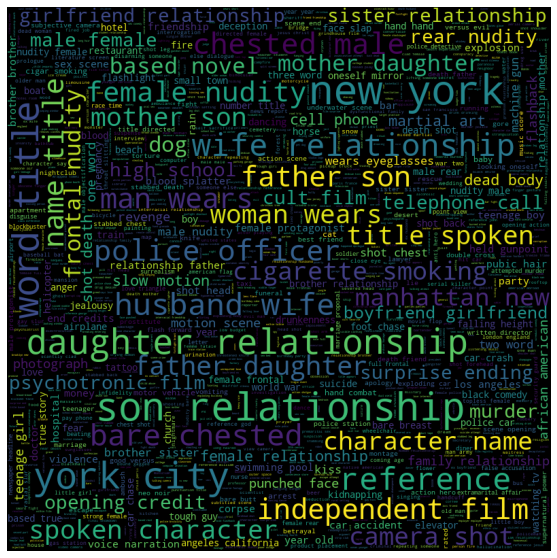

In [9]:
plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')
words = movie_df['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
      word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=1500, stopwords=STOPWORDS, max_font_size= 60,width=800,height=800)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [10]:
def jaccard_sim(str1, str2):
    a = set(str1.split(','))
    b = set(str2.split(','))
    c = a.intersection(b)
    return(float(len(c)) / (len(a) + len(b) - len(c)))

## Content Based Recommender (Spatial Cosine):

### Converting genres into a single list feature for each movie

In [16]:
genres_lst = list()
genres_columns = genres_onehot.columns.to_list()
for index, row in movie_df.iterrows():
  local_genre_lst = list()
  genre_chunks = row['genres'].split(',')
  for g in genres_columns:
    if (g in genre_chunks):
      local_genre_lst.append(1)
    else:
      local_genre_lst.append(0)
  genres_lst.append(local_genre_lst)

movie_df['genre_binary_label'] = genres_lst

### Merging Movie and Ratings dataframes

In [17]:
rating_df_mod = rating_df.drop(['name'], axis = 1)
rating_df_mod.fillna(-1, inplace=True)
lst_col = rating_df_mod.values.tolist()
rating_df_mod['rating_binary_label'] = lst_col
movie_merged_df = pd.merge(movie_df, rating_df_mod, on='movie_id', how='left')

### Calculating the distance between the target and all othe movies in the dataframe

In [18]:
def calculate_distance(target_id):
  score_list = list()
  index_list = list()
  test1 =  movie_merged_df[movie_merged_df.index == target_id]
  for index, row in movie_merged_df.iterrows():
      test1_rate = test1.rating_binary_label.to_list()[0]
      test1_genre = test1.genre_binary_label.to_list()[0]
      test1_keywords = test1.keywords.iloc[0]
      test1_storyline = test1['story_line_embeded'].tolist()
    
      test2_rate = row.rating_binary_label
      test2_genre = row.genre_binary_label
      test2_keywords = row.keywords
      test2_storyline = row['story_line_embeded']

      rate_score = spatial.distance.cosine(test1_rate, test2_rate)
      genre_score = spatial.distance.cosine(test1_genre, test2_genre)
      storyline_score = spatial.distance.cosine(test1_storyline, test2_storyline)
      key_score = 1 - jaccard_sim(test1_keywords, test2_keywords)

      final_score = 1.5* storyline_score + 2*key_score + rate_score + genre_score
      movie_merged_df.loc[index, 'score'] = final_score
      score_list.append(final_score)
      index_list.append(index)
  return (np.array(score_list), np.array(index_list))

### Testing content based recommeder:
Lets test Avengers Endgame and see what we get from the recommeder system.

In [21]:
score_list, index_list = calculate_distance('tt4154796')
k = 10
idx = np.argpartition(score_list, k)
recomm_indexes = list(index_list[idx[:k]])
result = movie_merged_df[movie_merged_df.index.isin(recomm_indexes)].sort_values(by=['score'],
                                                                        ascending=True)
result

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,name,org_name,date,title_year,point,point_volume,metascore,user_reviews,critic_reviews,director,writer,story_line,cast,genres,country,language,budget,world_gross,usa_gross,runtime,production_companies,dollar_budget,w_gross_money,u_gross_money,inflation_coeff,casts_id,BlogPage,CompPage,HomePage,release_month,release_day,keywords,Drama,Documentary,Comedy,Thriller,Romance,Action,Horror,Crime,...,ones_count,ones_percent,all_average,all_count,minor_average,minor_count,young_average,young_count,adult_average,adult_count,senior_average,senior_count,male_all_average,male_all_count,male_minor_average,male_minor_count,male_young_average,male_young_count,male_adult_average,male_adult_count,male_senior_average,male_senior_count,female_all_average,female_all_count,female_minor_average,female_minor_count,female_young_average,female_young_count,female_adult_average,female_adult_count,female_senior_average,female_senior_count,top_thousand_average,top_thousand_count,us_users_average,us_users_count,non_us_users_average,non_us_users_count,rating_binary_label,score
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt4154796,Avengers: Endgame,Avengers: Endgame,2019-04-26,2019.0,8.4,759878.0,78.0,8878.0,557.0,"Anthony Russo, Joe Russo","Christopher Markus,Stephen McFeely,14 more cre...",After the devastating events of Avengers: Infi...,"Robert Downey Jr.,Mark Ruffalo,Scarlett Johans...","Action,Adventure,Drama,Sci-Fi",USA,English,$356000000,$2797800564,$858373000,181.0,"Marvel Studios,Walt Disney Pictures",356000000.0,2.797801e+09,858373000.0,1.018646,"/name/nm0000375/,/name/nm0749263/,/name/nm0424...",0,0,0,4.0,26.0,"time-travel,superhero,super-villain,cosmic,mar...",1,0,0,0,0,1,0,0,...,19780,2.6,8.4,775024,8.7,2519,8.6,178772,8.3,206259,8.1,48370,8.3,407566,8.5,1502,8.5,137246,8.2,170942,8.0,39566,8.5,71222,8.7,324,8.6,26805,8.4,27549,8.5,6841,7.7,662,8.5,80421,8.2,232904,"[286433.0, 37.0, 166118.0, 21.4, 147131.0, 19....",0.000000
tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018-04-27,2018.0,8.4,799396.0,68.0,4272.0,611.0,"Anthony Russo, Joe Russo","Christopher Markus,Stephen McFeely,14 more cre...",As the Avengers and their allies have continue...,"Robert Downey Jr.,Mark Ruffalo,Scarlett Johans...","Action,Adventure,Sci-Fi",USA,English,$321000000,$2048359754,$678815482,149.0,"Marvel Studios,Jason Roberts Productions,South...",321000000.0,2.048360e+09,678815482.0,1.040853,"/name/nm0000375/,/name/nm0749263/,/name/nm0424...",0,0,0,4.0,27.0,"death-of-recurring-character,superhero,supervi...",0,0,0,0,0,1,0,0,...,13658,1.7,8.4,809018,8.8,2391,8.6,196632,8.3,217743,8.1,47326,8.4,447984,8.7,1657,8.6,156354,8.3,183000,8.1,39289,8.4,77575,8.7,331,8.5,30634,8.3,28794,8.2,6606,7.7,699,8.5,87967,8.3,258660,"[279505.0, 34.5, 204460.0, 25.3, 168805.0, 20....",1.956838
tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015-05-01,2015.0,7.3,723883.0,66.0,1307.0,692.0,Joss Whedon,"Joss Whedon,Stan Lee",Tony Stark creates the Ultron Program to prote...,"Robert Downey Jr.,Mark Ruffalo,Scarlett Johans...","Action,Adventure,Sci-Fi",USA,English,$250000000,$1402809540,$459005868,141.0,"Marvel Studios,Walt Disney Pictures",250000000.0,1.402810e+09,459005868.0,1.098100,"/name/nm0000375/,/name/nm0749263/,/name/nm0424...",0,0,0,5.0,1.0,"superhero,marvel-cinematic-universe,artificial...",0,0,0,0,0,1,0,0,...,10448,1.4,7.3,728564,7.1,970,7.4,179871,7.2,232684,7.3,48656,7.3,425930,7.0,689,7.3,142379,7.2,195734,7.2,40763,7.6,81408,7.6,125,7.7,32730,7.5,32666,7.6,6815,7.0,753,7.4,82549,7.2,256521,"[87899.0, 12.1, 87602.0, 12.0, 188049.0, 25.8,...",2.432744
tt0848228,The Avengers,The Avengers,2012-05-04,2012.0,8.0,1242238.0,69.0,1939.0,755.0,Joss Whedon,"Joss Whedon,Zak Penn","Nick Fury is the director of S.H.I.E.L.D., an ...","Robert Downey Jr.,Mark Ruffalo,Scarlett Johans...","Action,Adventure,Sci-Fi",USA,English,$220000000,$1518815515,$623357910,143.0,"Marvel Studios,Paramount Pictures",220000000.0,1.518816e+09,6233

## Collaborative Filtering Part:
Here, we want to also factor in the User part, instead of just looking at each movie, we will consider user likings too.

In [22]:
links_small_df = pd.read_csv('/content/drive/MyDrive/imdb_datasets/links_small.csv', index_col=0)
ratings_small_df = pd.read_csv('/content/drive/MyDrive/imdb_datasets/ratings_small.csv')
small_df = ratings_small_df.merge(links_small_df, on='movieId')
small_df.head()

,userId,movieId,rating,timestamp,imdbId
0,1,31,2.5,1260759144,tt0112792
1,7,31,3.0,851868750,tt0112792
2,31,31,4.0,1273541953,tt0112792
3,32,31,4.0,834828440,tt0112792
4,36,31,3.0,847057202,tt0112792


### Checking the distribution of ratings:

MU : 0.14685476211151335 Std : 0.017022787228985006


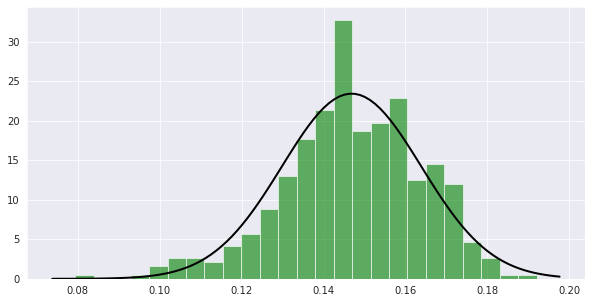

In [32]:
small_df['rating'] = small_df['rating'] / 5
modified_small = small_df.groupby(by='userId').count()
index_list = modified_small[modified_small.imdbId >= 50].index.to_list()
df = small_df[small_df.userId.isin(index_list)]
rating_dist_list = df.groupby(by='userId').mean().rating.values.tolist()
mu, std = norm.fit(rating_dist_list)
print('MU :', mu, 'Std :', std)
plt.figure(figsize=(10,5))
plt.hist(rating_dist_list, bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

### Using Surprise library and SVD to cross validate and come up with a prediction system

In [29]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(small_df[['userId', 'movieId', 'rating']], reader)
algo = SVD()
cross_result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

## Hybrid Recommender:

The method takes a movie ID alongside a User ID. Imagine some user liked a specific movie and is looking to find similiar movies. By using the content based recommender, first we find the 30 most similar titles and then use the SVD algorithm in order to rank these titles for that user. Finally, top results are returned.

In [33]:
def hybrid_recommender(imdb_movie_id, userId, number_of_results = 10):
  score_list, index_list = calculate_distance(imdb_movie_id)
  k = 30
  idx = np.argpartition(score_list, k)
  recomm_indexes = list(index_list[idx[:k]])
  results_df = movie_merged_df[movie_merged_df.index.isin(recomm_indexes)]
  result_index_list = results_df.index.to_list()
  est_scores = list()
  for i in result_index_list:
    is_present = len(small_df[small_df['imdbId'] == i])
    if (is_present > 0):
      temp_movieId = small_df[small_df['imdbId'] == i].iloc[0].movieId
      est_scores.append(algo.predict(userId,temp_movieId).est)
    else:
      est_scores.append(np.NaN)
  results_df['est_scores'] = est_scores  
  return(results_df.sort_values(by=['est_scores'],ascending=False)[0:number_of_results])

In [34]:
hybrid_recommender('tt4154796', 1, 5) 

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,name,org_name,date,title_year,point,point_volume,metascore,user_reviews,critic_reviews,director,writer,story_line,cast,genres,country,language,budget,world_gross,usa_gross,runtime,production_companies,dollar_budget,w_gross_money,u_gross_money,inflation_coeff,casts_id,BlogPage,CompPage,HomePage,release_month,release_day,keywords,Drama,Documentary,Comedy,Thriller,Romance,Action,Horror,Crime,...,ones_percent,all_average,all_count,minor_average,minor_count,young_average,young_count,adult_average,adult_count,senior_average,senior_count,male_all_average,male_all_count,male_minor_average,male_minor_count,male_young_average,male_young_count,male_adult_average,male_adult_count,male_senior_average,male_senior_count,female_all_average,female_all_count,female_minor_average,female_minor_count,female_young_average,female_young_count,female_adult_average,female_adult_count,female_senior_average,female_senior_count,top_thousand_average,top_thousand_count,us_users_average,us_users_count,non_us_users_average,non_us_users_count,rating_binary_label,score,est_scores
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt2015381,Guardians of the Galaxy,Guardians of the Galaxy,2014-08-01,2014.0,8.0,1024649.0,76.0,1407.0,721.0,James Gunn,"James Gunn,Nicole Perlman,9 more credits",After stealing a mysterious orb in the far rea...,"Chris Pratt,Dave Bautista,Bradley Cooper,Micha...","Action,Adventure,Comedy,Sci-Fi",USA,English,$170000000,$772791172,$333176600,121.0,"Marvel Studios,Walt Disney Pictures,Moving Pic...",170000000.0,7.727912e+08,333176600.0,1.099199,"/name/nm0695435/,/name/nm1176985/,/name/nm0177...",0,0,0,8.0,1.0,"outer-space,bounty-hunter,tree,talking-animal,...",0,0,1,0,0,1,0,0,...,1.0,8.0,1029761,8.1,1206,8.1,249425,8.0,337442,8.0,75615,8.0,602528,8.1,840,8.1,193875,8.0,279002,7.9,62225,8.1,128404,8.2,181,8.1,49381,8.0,52503,8.1,11816,7.7,853,8.3,123564,7.9,362879,"[192692.0, 18.7, 240456.0, 23.4, 307494.0, 29....",2.780345,3.233353
tt0120737,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Fellowship of the Ring,2001-12-19,2001.0,8.8,1619664.0,92.0,5392.0,340.0,Peter Jackson,"J.R.R. Tolkien,Fran Walsh",An ancient Ring thought lost for centuries has...,"Alan Howard,Sean Astin,Sean Bean,Orlando Bloom...","Action,Adventure,Drama,Fantasy","New Zealand,USA","English,Sindarin",$93000000,$887934303,$315544750,178.0,"New Line Cinema,WingNut Films,The Saul Zaentz ...",93000000.0,8.879343e+08,315544750.0,1.470013,"/name/nm0397102/,/name/nm0000276/,/name/nm0000...",0,0,0,12.0,19.0,"ring,quest,hobbit,epic,elf,orc,based-on-novel,...",1,0,0,0,0,1,0,0,...,1.6,8.8,1631299,8.8,992,8.9,341741,8.8,633154,8.6,154350,8.8,980169,8.9,740,9.0,265410,8.8,515680,8.6,125960,8.8,218177,8.3,133,8.8,69501,8.7,108106,8.8,25224,8.6,918,8.8,242333,8.8,663551,"[618946.0, 37.9, 451744.0, 27.7, 309780.0, 19....",2.879124,3.219444
tt0167261,The Lord of the Rings: The Two Towers,The Lord of the Rings: The Two Towers,2002-12-18,2002.0,8.7,1450369.0,87.0,2574.0,324.0,Peter Jackson,"J.R.R. Tolkien,Fran Walsh",The continuing quest of Frodo and the Fellowsh...,"Bruce Allpress,John Bach,Cate Blanchett,Billy ...","Action,Adventure,Drama,Fantasy","New Zealand,USA","English,Sindarin,Old English",$94000000,$951227416,$342551365,179.0,"New Line Cinema,WingNut Films,The Saul Zaentz ...",94000000.0,9.512274e+08,342551365.0,1.446772,"/name/nm0021600/,/name/nm0045324/,/name/nm0000...",0,0,0,12.0,18.0,"middle-earth,hobbit,epic,wizard,mission,dwarf,...",1,0,0,0,0,1,0,0,...,1.4,8.7,1460196,8.8,863,8.9,310947,8.7,570920,8.5,131592,8.7,884447,8.8,646,8.9,243710,8.7,466651,8.5,107450,8.7,192326,8.3,116,8.8,61164,8.6,96060,8.6,21586,8.5,901,8.7,214244,8.7,598284,"[507826.0, 34.8, 412719.0, 28.3, 304502.0, 20....",2.887964,3.131637
tt0848228,The Avengers,The Avengers,2012-05-04,2012.0,8.0,1242238.0,69.0,1939.0,755.0,Joss Whedon,"Joss Whedon,Zak Penn","Nick Fury is the director of S.H.I.E.L.D., an ...","Robert Downey Jr.,Mark Ruffal